In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# Load and preprocess your data (using your existing code)
try:
    gspc_df = pd.read_csv('gspc_daily_price.csv', parse_dates=['Date'], encoding='latin1')
except UnicodeDecodeError:
    gspc_df = pd.read_csv('gspc_daily_price.csv', parse_dates=['Date'], encoding='cp1252')
vix_df = pd.read_csv('vix_daily_price.csv', parse_dates=['Date'])
sentiment_df = pd.read_csv('news_sentiment_data.csv', parse_dates=['date'])

gspc_df.rename(columns={'Close ': 'Close', 'Open ': 'Open', 'High ': 'High', 'Low ': 'Low', 'Volume ': 'Volume'}, inplace=True)
vix_df.rename(columns={'Close ': 'Close', 'Open ': 'Open', 'High ': 'High', 'Low ': 'Low'}, inplace=True)
sentiment_df.rename(columns={'date': 'Date'}, inplace=True)


gspc_df.sort_values(by='Date', inplace=True)
vix_df.sort_values(by='Date', inplace=True)
sentiment_df.sort_values(by='Date', inplace=True)

df = pd.merge(gspc_df, vix_df, on='Date', suffixes=('_sp500', '_vix'))
df = pd.merge(df, sentiment_df, on='Date', how='left')
df.fillna(0, inplace=True)

df.columns = df.columns.str.replace('\xa0', '')

def calculate_rsi(data, window=14):
    delta = data['Close_sp500'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI_14'] = calculate_rsi(df)
df['Close_sp500'] = pd.to_numeric(df['Close_sp500'], errors='coerce')
df.fillna(0, inplace=True)

C:\Users\mehdi\AppData\Local\Temp\ipykernel_15664\4109938140.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gspc_df = pd.read_csv('gspc_daily_price.csv', parse_dates=['Date'], encoding='latin1')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_15664\4109938140.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vix_df = pd.read_csv('vix_daily_price.csv', parse_dates=['Date'])


In [24]:
# Prepare data for LSTM
merged_data = df.copy() # Make a copy so original dataframe is not altered.
merged_data.rename(columns={'Close_sp500': 'Close_SP500', 'Open_sp500': 'Open_SP500', 'High_sp500': 'High_SP500', 'Low_sp500': 'Low_SP500', 'Volume': 'Volume_SP500', 'RSI_14': 'RSI', 'Close_vix': 'Close_VIX', 'News Sentiment': 'News Sentiment'}, inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data[['Close_SP500', 'Open_SP500', 'High_SP500', 'Low_SP500', 'Volume_SP500', 'RSI', 'Close_VIX', 'News Sentiment']])

# Function to create dataset
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10
X, y = create_dataset(data_scaled, look_back)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build and train LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    Dropout(0.2),  # Add dropout
    LSTM(100, return_sequences=False),
    Dropout(0.2),  # Add dropout
    Dense(50, activation='relu'), #added activation function.
    Dense(1)
])

# Set learning Rate
optimizer = Adam(learning_rate=0.001) 

# Compile model
model.compile(optimizer=optimizer, loss='mean_absolute_error')


# Train the model
epochs = 100 #increase epochs.
batch_size = 32 #increase batch size.
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/100


C:\Users\mehdi\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.3417 - val_loss: 0.0952
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1460 - val_loss: 0.2130
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1028 - val_loss: 0.1085
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0891 - val_loss: 0.0911
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0752 - val_loss: 0.0890
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0744 - val_loss: 0.0887
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0761 - val_loss: 0.0882
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0697 - val_loss: 0.0889
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0677 - val_loss: 0.0983
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0660 - val_loss: 0.0899
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0583 - val_loss: 0.0917
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0615 - val_loss: 0.0896
E

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Mean Absolute Error (MAE): 69.20
Mean Squared Error (MSE): 6516.72
R^2 Score: 0.74


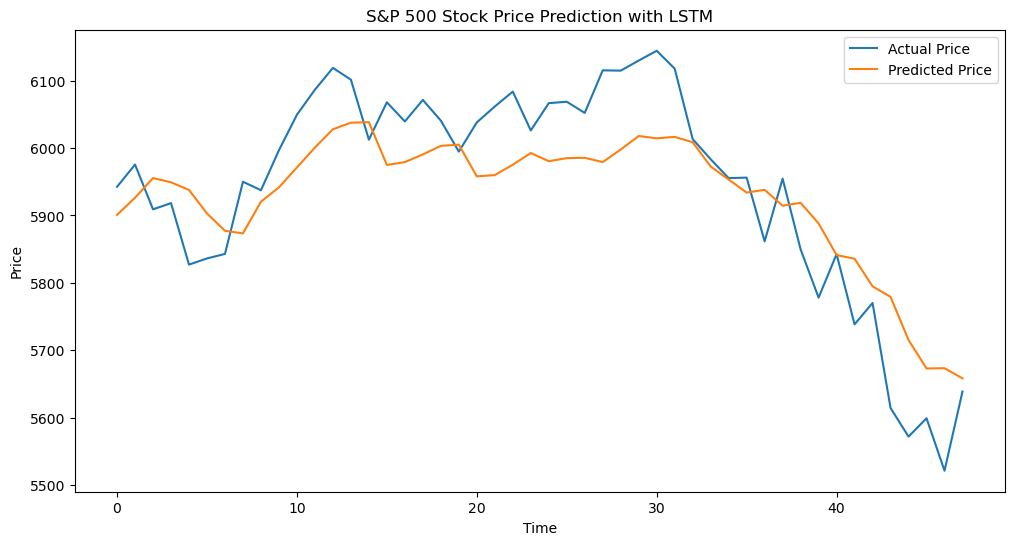

In [25]:
# Predict and evaluate
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(np.column_stack([y_test] + [np.zeros(y_test.shape)] * (X_test.shape[2] - 1)))[:, 0]
y_pred_inv = scaler.inverse_transform(np.column_stack([y_pred.flatten()] + [np.zeros(y_pred.shape)] * (X_test.shape[2] - 1)))[:, 0]

# Calculate MAE, MSE, r2
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.legend()
plt.title('S&P 500 Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [26]:
# Predict tomorrow's closing price
last_lookback = data_scaled[-look_back:].reshape(1, look_back, X_train.shape[2])
tomorrow_pred = model.predict(last_lookback)
tomorrow_price = scaler.inverse_transform(np.column_stack([tomorrow_pred.flatten()] + [np.zeros(tomorrow_pred.shape)] * (X_train.shape[2] - 1)))[:, 0]

#Get todays close
today_close = df['Close_sp500'].iloc[-1]
price_change = tomorrow_price[0] - today_close
percentage_change = (price_change/today_close) * 100

print(f"Predicted Closing Price for Tomorrow: ${tomorrow_price[0]:.2f}")
print(f"Predicted Change: {price_change:.2f} points ({percentage_change:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Closing Price for Tomorrow: $5689.38
Predicted Change: 14.26 points (0.25%)
